In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from community import community_louvain
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, TransformerConv

# Load the log-normalized data
data_log_normalized = pd.read_csv('K27M_log_normalized.csv')

# Remove duplicate gene names
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Ensure the correct dimensions for expression data
num_genes, num_cells = expression_data.shape

# Create a k-NN graph based on cell similarity
knn_graph = kneighbors_graph(expression_data.T, n_neighbors=10, include_self=False)
edges = np.array(knn_graph.nonzero()).T
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Define the transformer-based attention model
class TransformerAttentionModel(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(TransformerAttentionModel, self).__init__()
        self.conv1 = TransformerConv(in_feats, h_feats, heads=4)
        self.conv2 = TransformerConv(h_feats * 4, num_classes, heads=4, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Prepare data for training
features = torch.tensor(expression_data.T, dtype=torch.float32)  # Transpose to match cells
in_feats = features.shape[1]
h_feats = 64
num_classes = 3  # Number of clusters

data = Data(x=features, edge_index=edge_index)
model = TransformerAttentionModel(in_feats, h_feats, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, out.argmax(dim=1))
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Final clustering results using Louvain community detection
model.eval()
out = model(data.x, data.edge_index).detach().numpy()
G = nx.from_scipy_sparse_matrix(knn_graph)
partition = community_louvain.best_partition(G, weight='weight')
cluster_labels = np.array([partition[i] for i in range(num_cells)])

# Ensure the length matches
print(f"Number of cluster labels: {len(cluster_labels)}")
print(f"Number of cells: {num_cells}")

# Save the cluster labels
cluster_df = pd.DataFrame({'Cell': np.arange(num_cells), 'Cluster': cluster_labels})
cluster_df.to_csv('K27M_cluster_labels.csv', index=False)


Epoch 0, Loss: 0.41255250573158264
Epoch 10, Loss: 0.0
Epoch 20, Loss: 0.0
Epoch 30, Loss: 0.0
Epoch 40, Loss: 0.0
Epoch 50, Loss: 0.0
Epoch 60, Loss: 0.0
Epoch 70, Loss: 0.0
Epoch 80, Loss: 0.0
Epoch 90, Loss: 0.0
Number of cluster labels: 2458
Number of cells: 2458


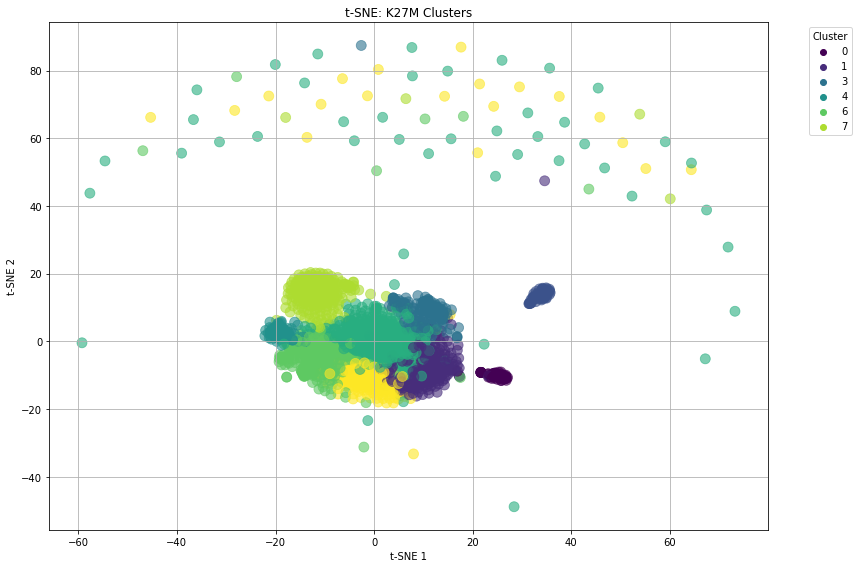

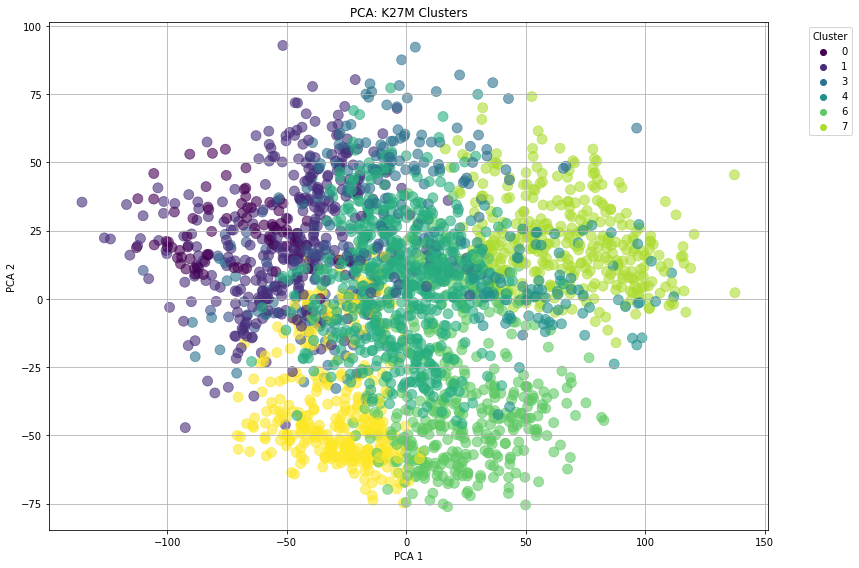

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Read the saved cluster labels
cluster_df = pd.read_csv('K27M_cluster_labels.csv')

# Load the log-normalized data
data_log_normalized = pd.read_csv('K27M_log_normalized.csv')

# Remove duplicate gene names and extract expression data
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Ensure the correct dimensions for expression data
num_genes, num_cells = expression_data.shape

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(expression_data.T)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_data.T)

# Add t-SNE and PCA results to the cluster dataframe
cluster_df['tSNE1'] = tsne_result[:, 0]
cluster_df['tSNE2'] = tsne_result[:, 1]
cluster_df['PCA1'] = pca_result[:, 0]
cluster_df['PCA2'] = pca_result[:, 1]

# Plot t-SNE
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Cluster', data=cluster_df, palette='viridis', s=100, alpha=0.6, edgecolor=None)
plt.title('t-SNE: K27M Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('K27M_tsne_clustersGAT.jpg', format='jpeg', dpi=300)
plt.show()

# Plot PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=cluster_df, palette='viridis', s=100, alpha=0.6, edgecolor=None)
plt.title('PCA: K27M Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('K27M_pca_clustersGAT.jpg', format='jpeg', dpi=300)
plt.show()

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from community import community_louvain

# Load the log-normalized data
data_log_normalized = pd.read_csv('K27M_log_normalized.csv')

# Remove duplicate gene names and extract expression data
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Load the cluster labels
cluster_df = pd.read_csv('K27M_cluster_labels.csv')
cluster_labels = cluster_df['Cluster'].values

# Create a k-NN graph based on cell similarity
knn_graph = kneighbors_graph(expression_data.T, n_neighbors=10, include_self=False)
G = nx.from_scipy_sparse_matrix(knn_graph)

# Perform Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')
louvain_labels = np.array([partition[i] for i in range(expression_data.shape[1])])

# Perform Spectral Clustering on each Louvain community cluster
spectral_results = []

for cluster in np.unique(louvain_labels):
    cluster_idx = np.where(louvain_labels == cluster)[0]
    cluster_data = expression_data[:, cluster_idx]
    
    # Perform Spectral Clustering
    spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
    spectral_labels = spectral.fit_predict(cluster_data.T)
    
    # Get the top 10 genes for each spectral cluster
    for spectral_cluster in np.unique(spectral_labels):
        spectral_cluster_idx = np.where(spectral_labels == spectral_cluster)[0]
        cluster_gene_expr = cluster_data[:, spectral_cluster_idx].mean(axis=1)
        top_genes_idx = np.argsort(cluster_gene_expr)[-10:]
        top_genes = genes[top_genes_idx]
        
        for gene in top_genes:
            spectral_results.append([cluster, spectral_cluster, gene])

# Save the Spectral Clustering results
spectral_df = pd.DataFrame(spectral_results, columns=['Louvain_Cluster', 'Spectral_Cluster', 'Gene'])
spectral_df.to_csv('Spectral_Louvain_Cluster_genes.csv', index=False)

# Print the top 10 genes for Spectral Clustering
print("Top 10 genes for Spectral Clustering in each Louvain cluster:")
for cluster in np.unique(spectral_df['Louvain_Cluster']):
    cluster_genes = spectral_df[spectral_df['Louvain_Cluster'] == cluster]
    print(f"Louvain Cluster {cluster}: {', '.join(cluster_genes['Gene'].unique()[:10])}")


Top 10 genes for Spectral Clustering in each Louvain cluster:
Louvain Cluster 0: C1orf61, DBI, TUBA1B, ACTG1, H2AFZ, TUBB2B, MTRNR2L1, GAPDH, MTRNR2L8, MTRNR2L2
Louvain Cluster 1: HNRNPA1, KPNA2, MTRNR2L1, ARL6IP1, TUBA1B, ACTG1, CALM2, TUBA1A, MTRNR2L8, MTRNR2L2
Louvain Cluster 2: RPL41, RPS4X, ACTB, RPL5, MTRNR2L1, EEF1A1, ACTG1, TUBA1A, MTRNR2L8, MTRNR2L2
Louvain Cluster 3: TUBA1A, ACTG1, ACTB, CALM2, MTRNR2L1, TUBB2B, TUBA1B, GAPDH, MTRNR2L8, MTRNR2L2
Louvain Cluster 4: RPL7, RPL5, MTRNR2L1, ACTB, TUBA1A, ACTG1, EEF1A1, GAPDH, MTRNR2L8, MTRNR2L2
Louvain Cluster 5: RPL3, RPS3A, RPLP0, TUBA1A, FOS, RPSA, ACTB, RPL5, MTRNR2L8, MTRNR2L2
Louvain Cluster 6: CALM2, PTGDS, ACTB, DBNDD2, MTRNR2L8, FOS, TUBA1A, MBP, MTRNR2L2, PLP1
Louvain Cluster 7: RGS1, ACTB, B2M, TMSB4X, HLA-DRA, FTL, CD74, MTRNR2L8, SPP1, MTRNR2L2
Louvain Cluster 8: RPL5, RPS3A, GPM6B, RPL3, RPL7, GFAP, EEF1A1, CRYAB, MTRNR2L8, MTRNR2L2


In [5]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import TruncatedSVD
from community import community_louvain
from sklearn.neighbors import kneighbors_graph

# Load the log-normalized data
data_log_normalized = pd.read_csv('K27M_log_normalized.csv')

# Remove duplicate gene names and extract expression data
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Create a k-NN graph based on cell similarity
knn_graph = kneighbors_graph(expression_data.T, n_neighbors=10, include_self=False)
G = nx.from_scipy_sparse_matrix(knn_graph)

# Perform Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')
louvain_labels = np.array([partition[i] for i in range(expression_data.shape[1])])

# Perform SVD Clustering on each Louvain community cluster
svd_results = []

for cluster in np.unique(louvain_labels):
    cluster_idx = np.where(louvain_labels == cluster)[0]
    cluster_data = expression_data[:, cluster_idx]
    
    # Perform SVD
    svd = TruncatedSVD(n_components=10)
    svd_components = svd.fit_transform(cluster_data.T)
    
    # Get the top 10 genes for each SVD component
    for svd_component in range(svd_components.shape[1]):
        top_genes_idx = np.argsort(svd.components_[svd_component])[-10:]
        top_genes = genes[top_genes_idx]
        
        for gene in top_genes:
            svd_results.append([cluster, svd_component, gene])

# Save the SVD Clustering results
svd_df = pd.DataFrame(svd_results, columns=['Louvain_Cluster', 'SVD_Component', 'Gene'])
svd_df.to_csv('SVD_Louvain_Cluster_genes.csv', index=False)

# Print the top 10 genes for SVD Clustering
print("Top 10 genes for SVD Clustering in each Louvain cluster:")
for cluster in np.unique(svd_df['Louvain_Cluster']):
    cluster_genes = svd_df[svd_df['Louvain_Cluster'] == cluster]
    print(f"Louvain Cluster {cluster}: {', '.join(cluster_genes['Gene'].unique()[:10])}")

Top 10 genes for SVD Clustering in each Louvain cluster:
Louvain Cluster 0: RPL4, RPS3A, GNB2L1, RPL7, RPL5, RPS18, RPL3, EEF1A1, MTRNR2L8, MTRNR2L2
Louvain Cluster 1: TUBB, MTRNR2L1, EEF1A1, ACTB, ACTG1, GAPDH, TUBA1B, TUBA1A, MTRNR2L8, MTRNR2L2
Louvain Cluster 2: RPLP0, MTRNR2L1, ACTG1, RPS4X, RPL5, RPL41, TUBA1A, EEF1A1, MTRNR2L8, MTRNR2L2
Louvain Cluster 3: BCAN, MALAT1, B2M, TUBA1A, ACTG1, MTRNR2L1, ACTB, EEF1A1, MTRNR2L8, MTRNR2L2
Louvain Cluster 4: FTH1, SPP1, HLA-DRA, ACTB, B2M, TMSB4X, FTL, CD74, MTRNR2L8, MTRNR2L2
Louvain Cluster 5: RPL3, MTRNR2L1, ACTB, RPL5, RPL7, ACTG1, GAPDH, EEF1A1, MTRNR2L8, MTRNR2L2
Louvain Cluster 6: EEF1A1, RPS3A, RPLP0, FOS, RPSA, RPL5, TUBA1A, ACTB, MTRNR2L8, MTRNR2L2
Louvain Cluster 7: ACTB, PTGDS, CLDND1, SEPP1, DBNDD2, MTRNR2L8, MBP, TUBA1A, MTRNR2L2, PLP1


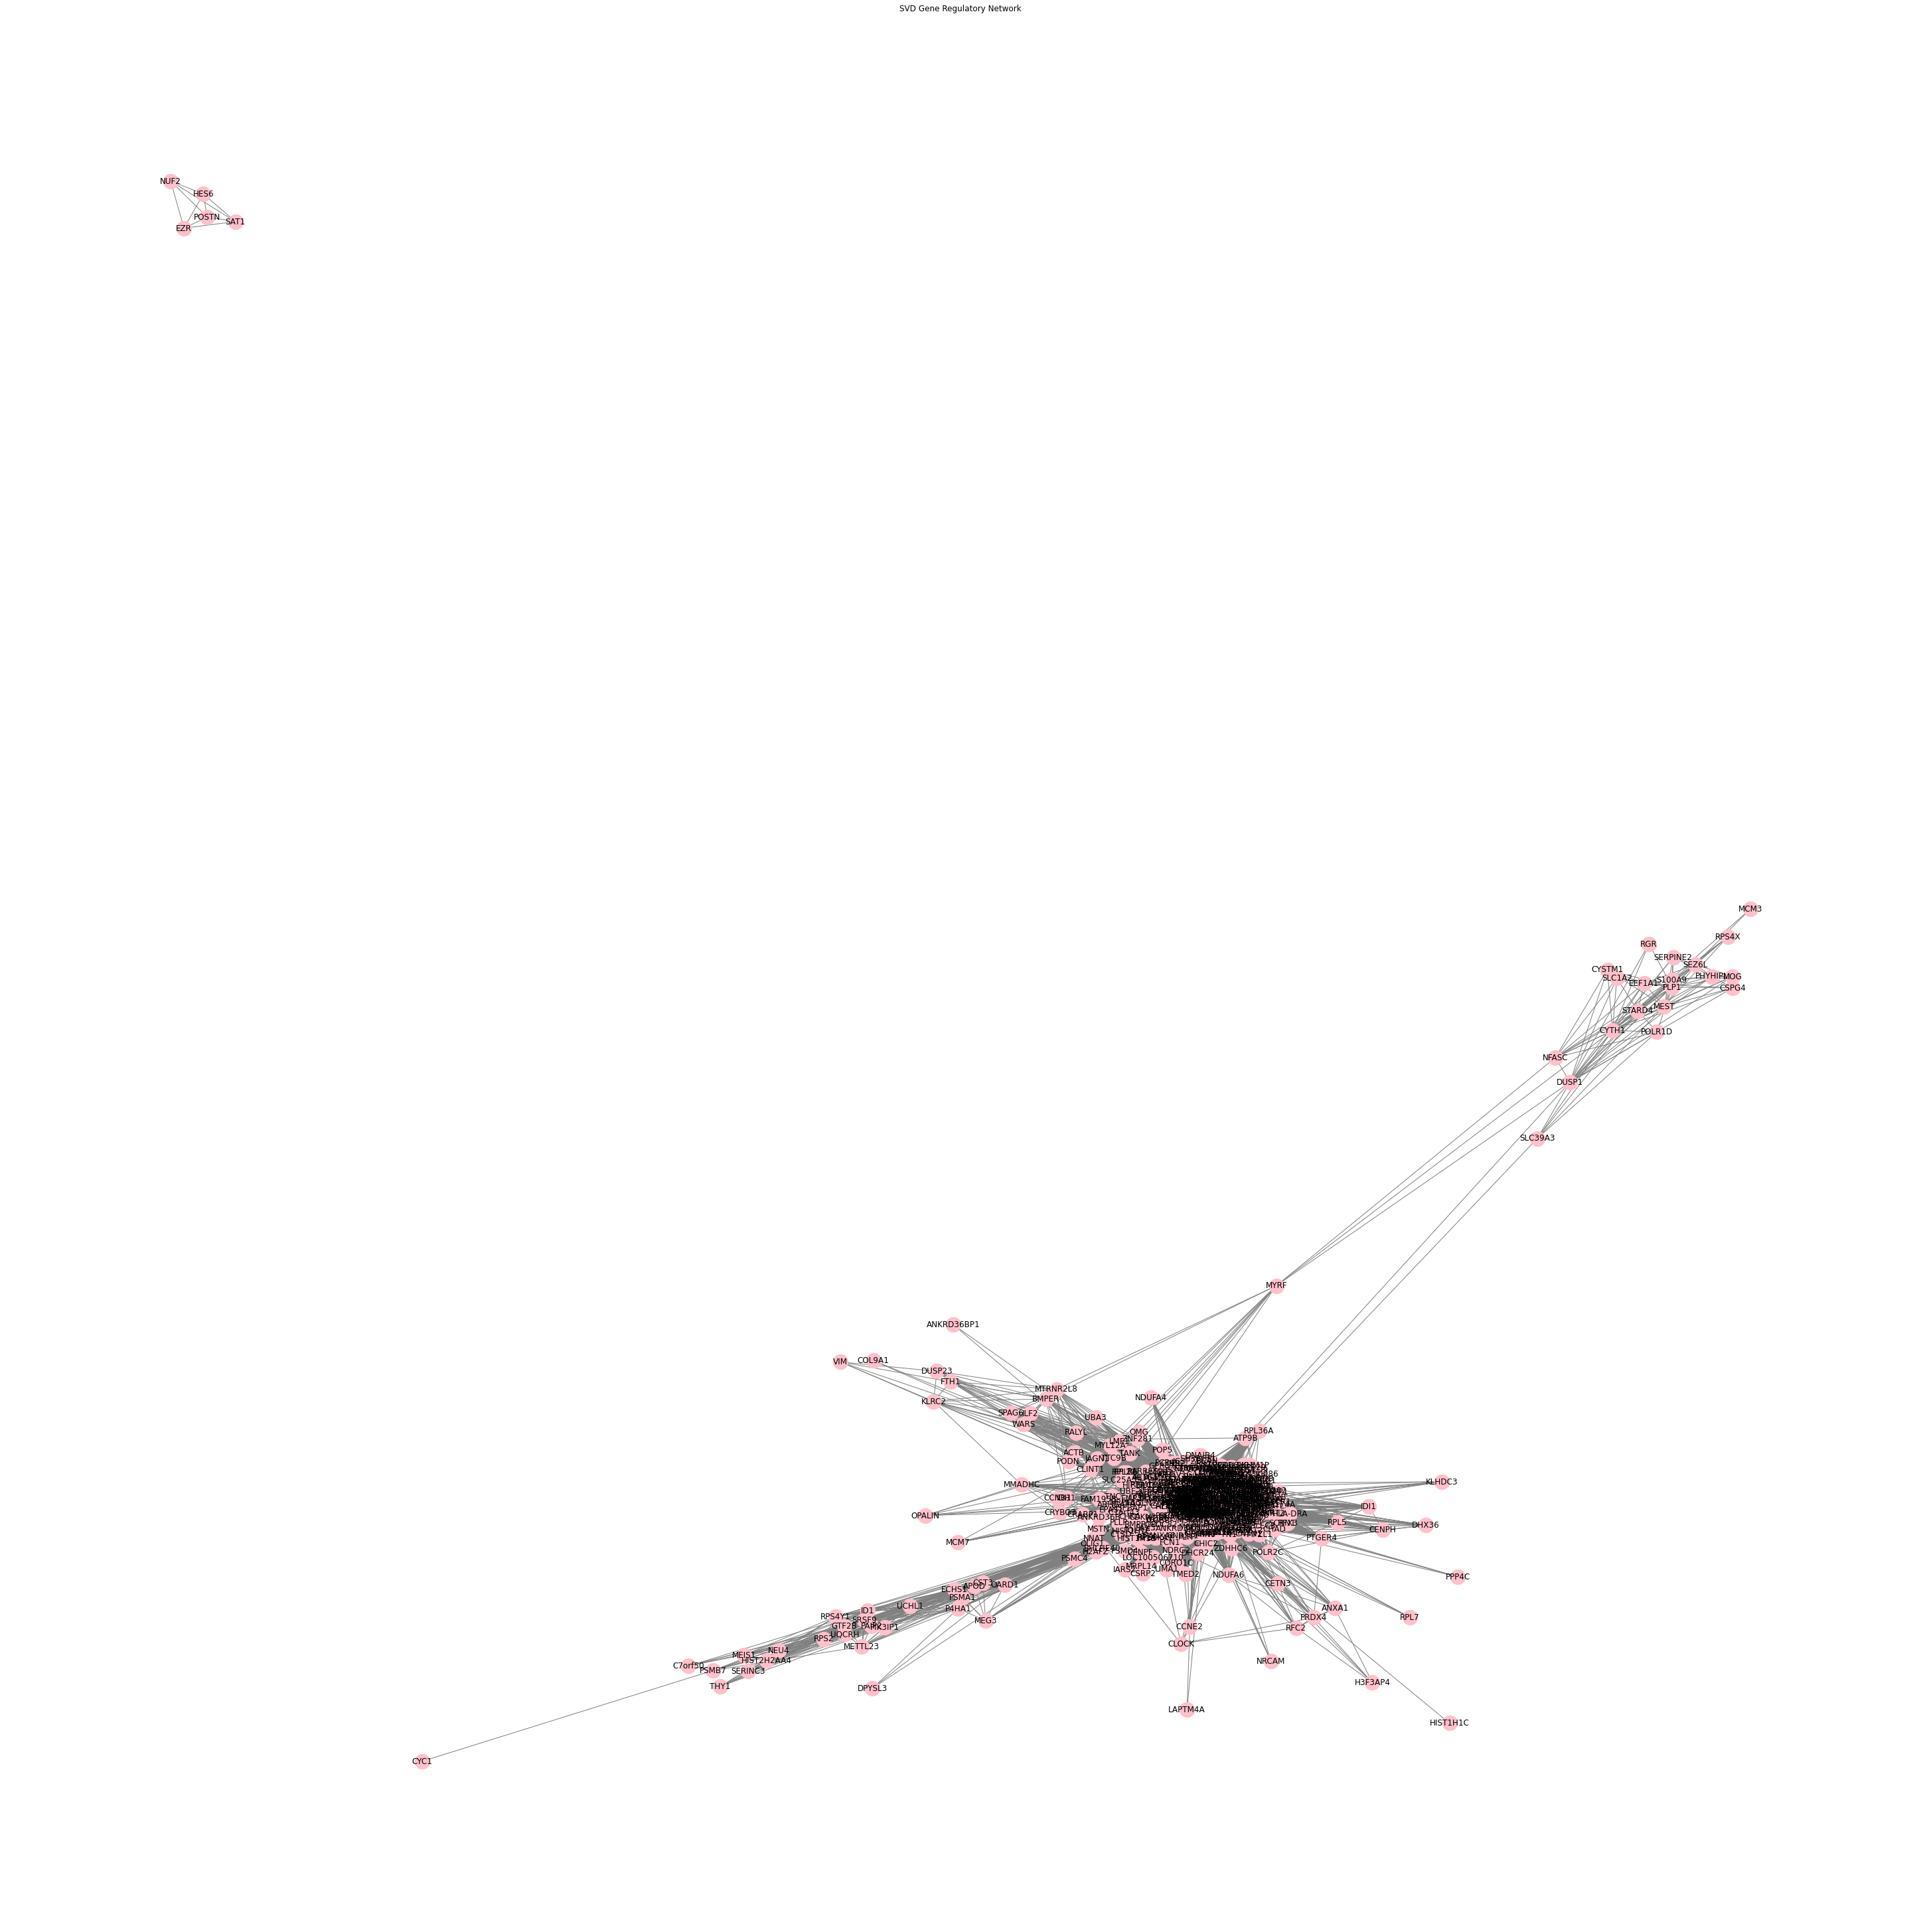

In [6]:
#GRN SVD clustering Network
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the SVD genes
svd_genes_df = pd.read_csv('SVD_Louvain_Cluster_genes.csv')
svd_genes = svd_genes_df['Gene'].unique()

# Create a GRN using SVD top genes
top_gene_data_svd = expression_data[np.isin(genes, svd_genes), :]
similarity_matrix_svd = cosine_similarity(top_gene_data_svd)
grn_graph_svd = nx.Graph()

for i in range(similarity_matrix_svd.shape[0]):
    for j in range(i + 1, similarity_matrix_svd.shape[1]):
        if similarity_matrix_svd[i, j] > 0.5:  # Set a threshold for similarity
            grn_graph_svd.add_edge(svd_genes[i], svd_genes[j], weight=similarity_matrix_svd[i, j])

# Compute centralities
centralities_svd = {
    'betweenness': nx.betweenness_centrality(grn_graph_svd),
    'degree': nx.degree_centrality(grn_graph_svd),
    'eigenvector': nx.eigenvector_centrality(grn_graph_svd),
    'closeness': nx.closeness_centrality(grn_graph_svd),
    'hubs': nx.hits(grn_graph_svd)[0]
}

# Save the centralities with gene names
centrality_svd_df = pd.DataFrame(centralities_svd).reset_index().rename(columns={'index': 'Gene'})
centrality_svd_df.to_csv('SVD_gene_centralities.csv', index=False)

# Plot the SVD GRN
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(grn_graph_svd)
nx.draw(grn_graph_svd, pos, with_labels=True, node_size=500, node_color='pink', edge_color='gray')
plt.title('SVD Gene Regulatory Network')
plt.savefig('SVD_gene_regulatory_network.jpg', format='jpeg', dpi=300)
plt.show()


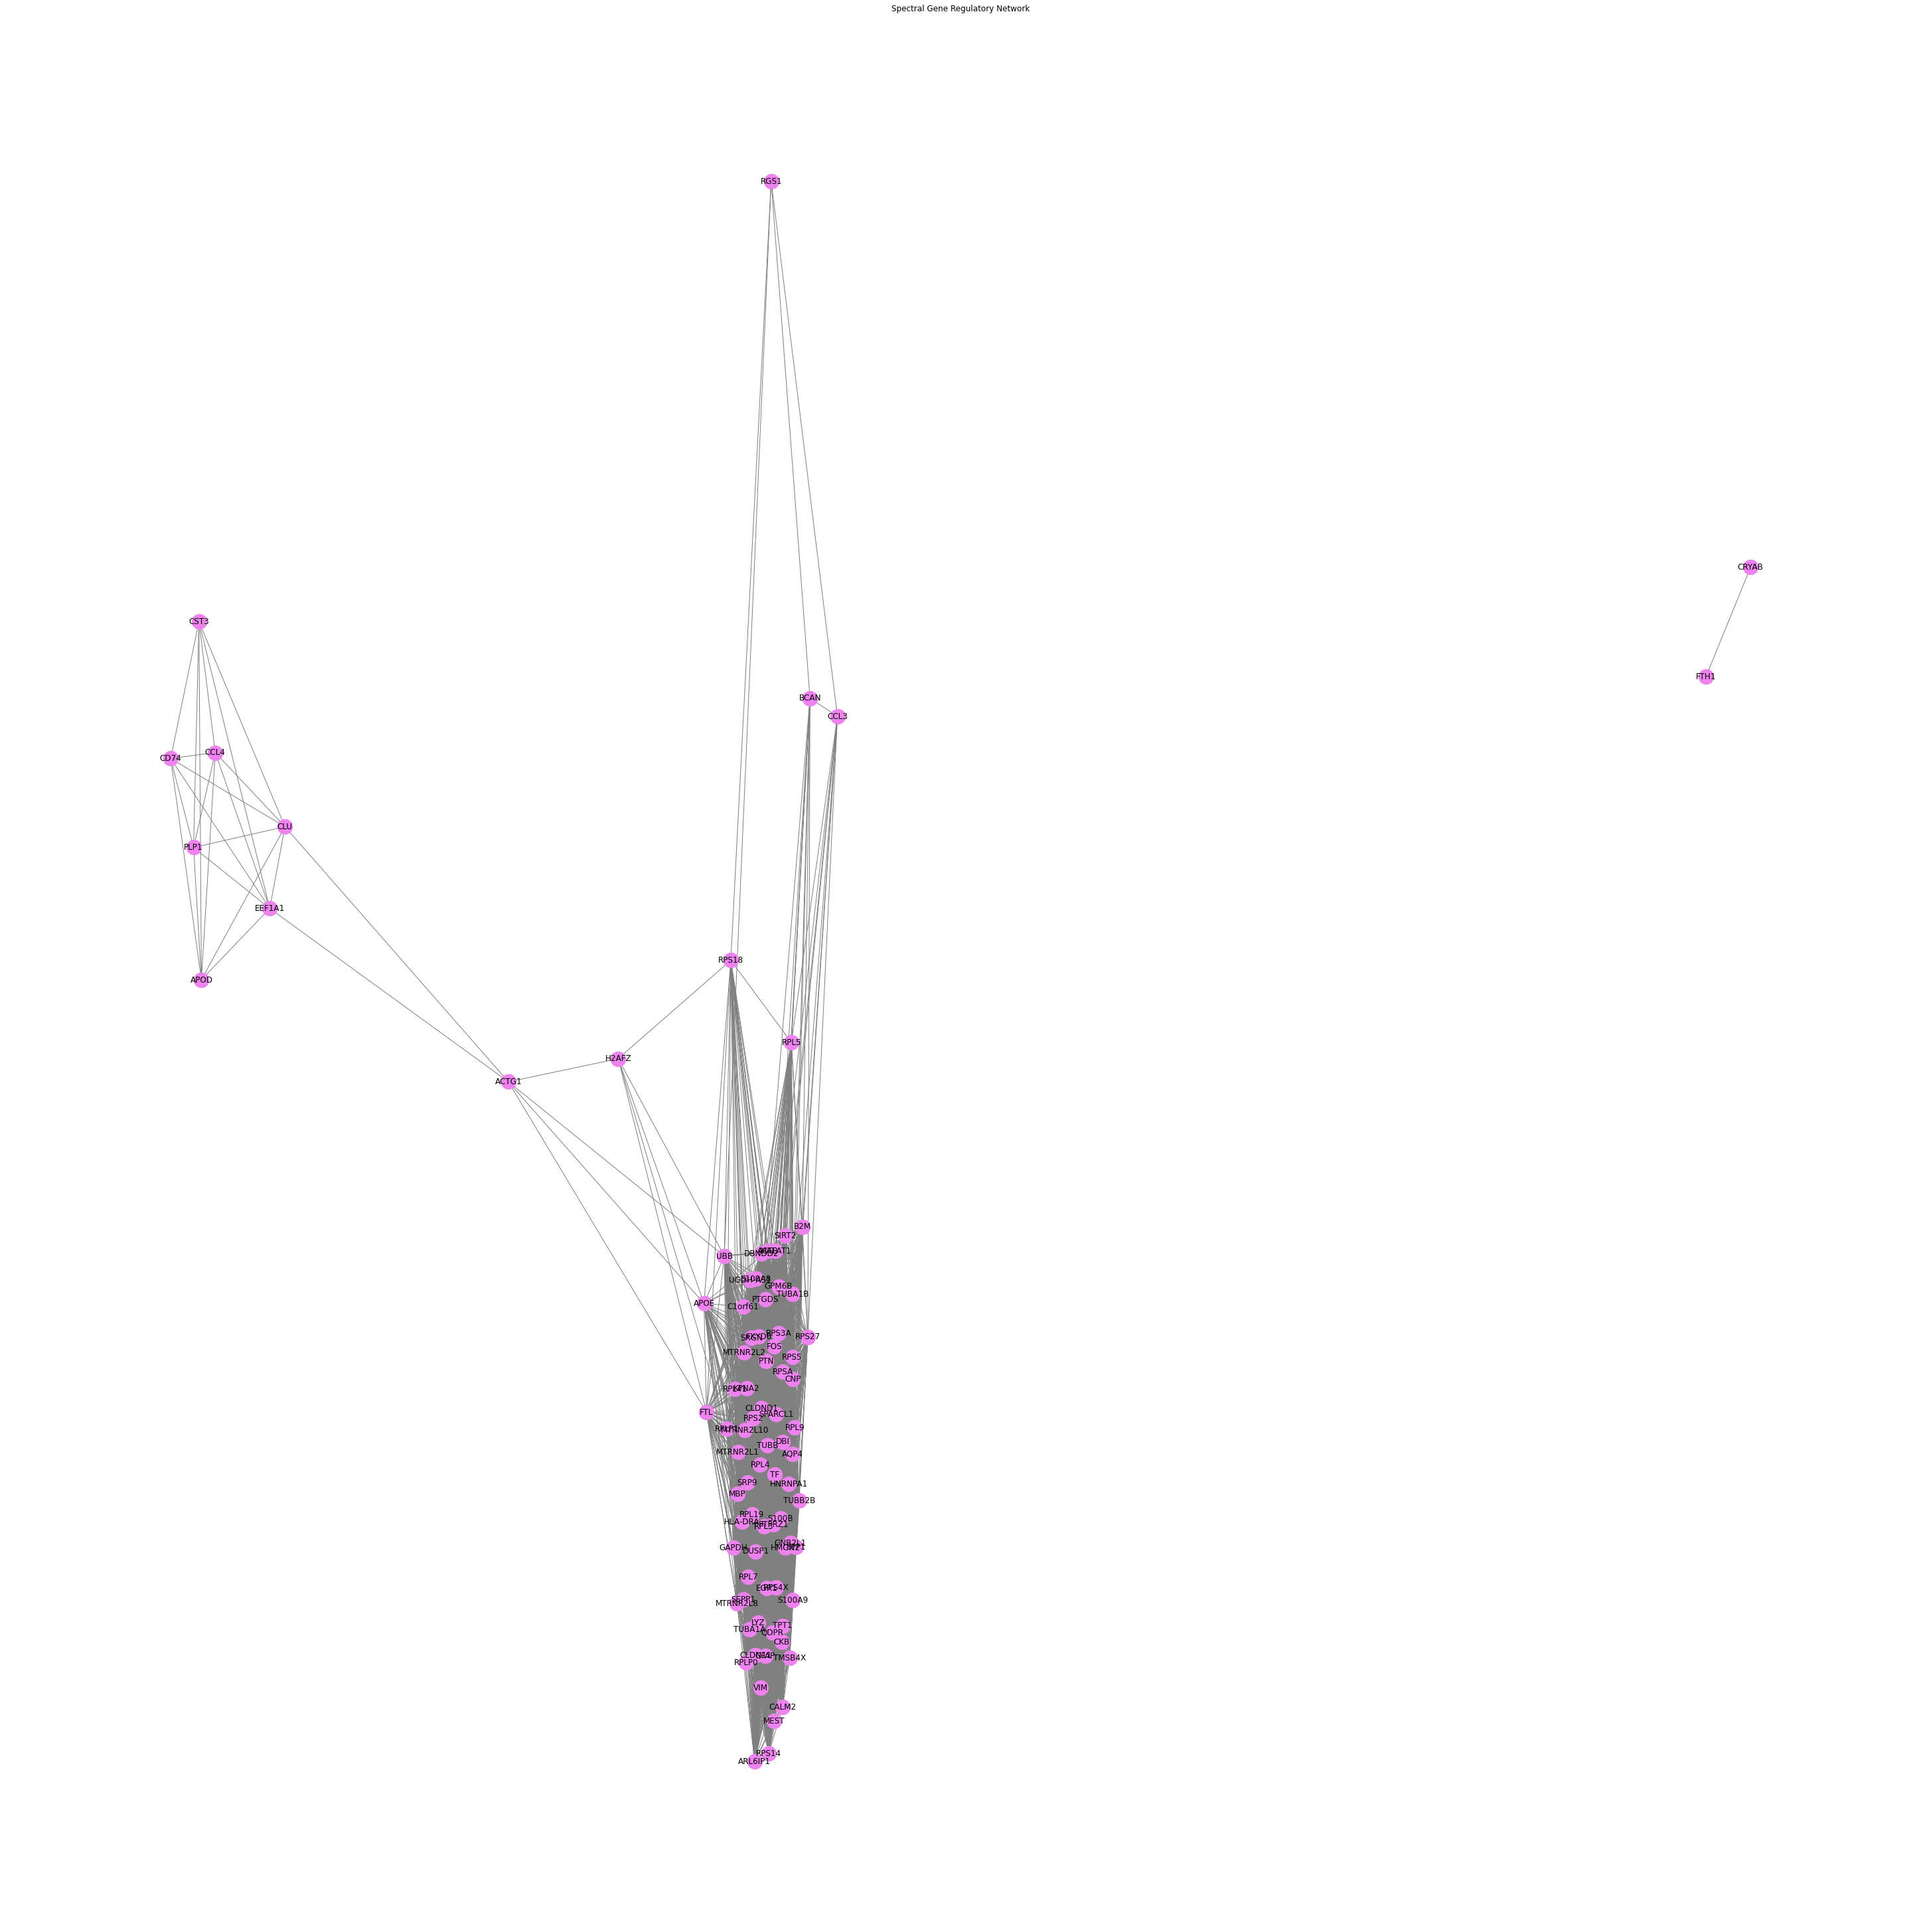

In [7]:
#Spectral Clustering GRN

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the Spectral Clustering genes
spectral_genes_df = pd.read_csv('Spectral_Louvain_Cluster_genes.csv')
spectral_genes = spectral_genes_df['Gene'].unique()

# Create a GRN using Spectral top genes
top_gene_data_spectral = expression_data[np.isin(genes, spectral_genes), :]
similarity_matrix_spectral = cosine_similarity(top_gene_data_spectral)
grn_graph_spectral = nx.Graph()

for i in range(similarity_matrix_spectral.shape[0]):
    for j in range(i + 1, similarity_matrix_spectral.shape[1]):
        if similarity_matrix_spectral[i, j] > 0.5:  # Set a threshold for similarity
            grn_graph_spectral.add_edge(spectral_genes[i], spectral_genes[j], weight=similarity_matrix_spectral[i, j])

# Compute centralities
centralities_spectral = {
    'betweenness': nx.betweenness_centrality(grn_graph_spectral),
    'degree': nx.degree_centrality(grn_graph_spectral),
    'eigenvector': nx.eigenvector_centrality(grn_graph_spectral),
    'closeness': nx.closeness_centrality(grn_graph_spectral),
    'hubs': nx.hits(grn_graph_spectral)[0]
}

# Save the centralities with gene names
centrality_spectral_df = pd.DataFrame(centralities_spectral).reset_index().rename(columns={'index': 'Gene'})
centrality_spectral_df.to_csv('Spectral_gene_centralities.csv', index=False)

# Plot the Spectral Clustering GRN
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(grn_graph_spectral)
nx.draw(grn_graph_spectral, pos, with_labels=True, node_size=500, node_color='violet', edge_color='gray')
plt.title('Spectral Gene Regulatory Network')
plt.savefig('Spectral_gene_regulatory_network.jpg', format='jpeg', dpi=300)
plt.show()


In [8]:
import pandas as pd
import numpy as np

# Load the log-normalized data
data_log_normalized = pd.read_csv('K27M_log_normalized.csv')
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Ensure expression_data is a 2D array
if expression_data.ndim == 1:
    expression_data = np.expand_dims(expression_data, axis=0)

# Load SVD and Spectral clustering gene lists
svd_genes_df = pd.read_csv('SVD_Louvain_Cluster_genes.csv')
spectral_genes_df = pd.read_csv('Spectral_Louvain_Cluster_genes.csv')

svd_genes = svd_genes_df['Gene'].unique()
spectral_genes = spectral_genes_df['Gene'].unique()

# Extract counts for SVD genes
svd_gene_indices = np.isin(genes, svd_genes)
svd_gene_data = expression_data[svd_gene_indices, :]

# Extract counts for Spectral genes
spectral_gene_indices = np.isin(genes, spectral_genes)
spectral_gene_data = expression_data[spectral_gene_indices, :]

# Ensure the extracted data is a 2D array
if svd_gene_data.ndim == 1:
    svd_gene_data = np.expand_dims(svd_gene_data, axis=0)
if spectral_gene_data.ndim == 1:
    spectral_gene_data = np.expand_dims(spectral_gene_data, axis=0)

# Binarize the data
svd_gene_data_binary = np.where(svd_gene_data > 0, 1, 0)
spectral_gene_data_binary = np.where(spectral_gene_data > 0, 1, 0)

# Optional: Print shapes for verification
print('SVD gene data shape:', svd_gene_data.shape)
print('Spectral gene data shape:', spectral_gene_data.shape)
print('SVD binary data shape:', svd_gene_data_binary.shape)
print('Spectral binary data shape:', spectral_gene_data_binary.shape)


SVD gene data shape: (557, 2458)
Spectral gene data shape: (88, 2458)
SVD binary data shape: (557, 2458)
Spectral binary data shape: (88, 2458)


SVD Gene Data BDM Changes (mean ± std): 16.30520646319569 ± 1296.7668787136442
Spectral Gene Data BDM Changes (mean ± std): -1201.659090909091 ± 1610.9057932387238


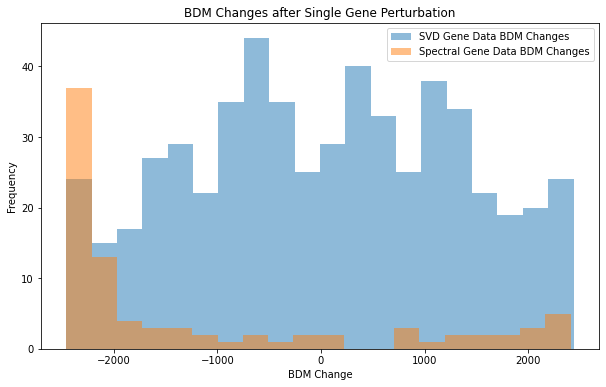

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simplified BDM computation function (actual implementation may vary)
def compute_bdm(matrix):
    # This function is a placeholder for the actual BDM computation.
    # Replace with the actual BDM calculation method or library.
    return np.sum(matrix)

# Function to perturb a single gene and return the perturbed matrix
def perturb_single_gene(matrix, gene_index):
    perturbed_matrix = matrix.copy()
    perturbed_matrix[gene_index, :] = 1 - perturbed_matrix[gene_index, :]  # Flip the entire row (gene)
    return perturbed_matrix

# Load the log-normalized data
data_log_normalized = pd.read_csv('K27M_log_normalized.csv')
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Load SVD and Spectral clustering gene lists
svd_genes_df = pd.read_csv('SVD_Louvain_Cluster_genes.csv')
spectral_genes_df = pd.read_csv('Spectral_Louvain_Cluster_genes.csv')

svd_genes = svd_genes_df['Gene'].unique()
spectral_genes = spectral_genes_df['Gene'].unique()

# Extract counts for SVD genes
svd_gene_indices = np.isin(genes, svd_genes)
svd_gene_data = expression_data[svd_gene_indices, :]

# Extract counts for Spectral genes
spectral_gene_indices = np.isin(genes, spectral_genes)
spectral_gene_data = expression_data[spectral_gene_indices, :]

# Ensure the extracted data is a 2D array
if svd_gene_data.ndim == 1:
    svd_gene_data = np.expand_dims(svd_gene_data, axis=0)
if spectral_gene_data.ndim == 1:
    spectral_gene_data = np.expand_dims(spectral_gene_data, axis=0)

# Binarize the data
svd_gene_data_binary = np.where(svd_gene_data > 0, 1, 0)
spectral_gene_data_binary = np.where(spectral_gene_data > 0, 1, 0)

# Compute initial BDM for SVD and Spectral gene data
bdm_svd_initial = compute_bdm(svd_gene_data_binary)
bdm_spectral_initial = compute_bdm(spectral_gene_data_binary)

# Compute BDM changes for each gene perturbation
svd_bdm_changes = []
spectral_bdm_changes = []

# Calculate BDM changes for SVD genes
for i in range(svd_gene_data_binary.shape[0]):
    perturbed_svd = perturb_single_gene(svd_gene_data_binary, i)
    bdm_svd_perturbed = compute_bdm(perturbed_svd)
    svd_bdm_changes.append({
        'Gene': svd_genes[i],
        'BDM Change': bdm_svd_perturbed - bdm_svd_initial
    })

# Calculate BDM changes for Spectral genes
for i in range(spectral_gene_data_binary.shape[0]):
    perturbed_spectral = perturb_single_gene(spectral_gene_data_binary, i)
    bdm_spectral_perturbed = compute_bdm(perturbed_spectral)
    spectral_bdm_changes.append({
        'Gene': spectral_genes[i],
        'BDM Change': bdm_spectral_perturbed - bdm_spectral_initial
    })

# Save BDM changes to CSV files
svd_bdm_changes_df = pd.DataFrame(svd_bdm_changes)
spectral_bdm_changes_df = pd.DataFrame(spectral_bdm_changes)

svd_bdm_changes_df.to_csv('SVD_BDM_Changes_Single_Gene.csv', index=False)
spectral_bdm_changes_df.to_csv('Spectral_BDM_Changes_Single_Gene.csv', index=False)

# Summarize results
print("SVD Gene Data BDM Changes (mean ± std):", np.mean(svd_bdm_changes_df['BDM Change']), "±", np.std(svd_bdm_changes_df['BDM Change']))
print("Spectral Gene Data BDM Changes (mean ± std):", np.mean(spectral_bdm_changes_df['BDM Change']), "±", np.std(spectral_bdm_changes_df['BDM Change']))

# Plot BDM changes
plt.figure(figsize=(10, 6))
plt.hist(svd_bdm_changes_df['BDM Change'], bins=20, alpha=0.5, label='SVD Gene Data BDM Changes')
plt.hist(spectral_bdm_changes_df['BDM Change'], bins=20, alpha=0.5, label='Spectral Gene Data BDM Changes')
plt.title('BDM Changes after Single Gene Perturbation')
plt.xlabel('BDM Change')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [1]:
#Repeat for IDHWT

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from community import community_louvain
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, TransformerConv

# Load the log-normalized data
data_log_normalized = pd.read_csv('IDHWT_log_normalized.csv')

# Remove duplicate gene names
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Ensure the correct dimensions for expression data
num_genes, num_cells = expression_data.shape

# Create a k-NN graph based on cell similarity
knn_graph = kneighbors_graph(expression_data.T, n_neighbors=10, include_self=False)
edges = np.array(knn_graph.nonzero()).T
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Define the transformer-based attention model
class TransformerAttentionModel(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(TransformerAttentionModel, self).__init__()
        self.conv1 = TransformerConv(in_feats, h_feats, heads=4)
        self.conv2 = TransformerConv(h_feats * 4, num_classes, heads=4, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Prepare data for training
features = torch.tensor(expression_data.T, dtype=torch.float32)  # Transpose to match cells
in_feats = features.shape[1]
h_feats = 64
num_classes = 3  # Number of clusters

data = Data(x=features, edge_index=edge_index)
model = TransformerAttentionModel(in_feats, h_feats, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, out.argmax(dim=1))
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.943089485168457
Epoch 10, Loss: 0.0
Epoch 20, Loss: 0.0
Epoch 30, Loss: 0.0
Epoch 40, Loss: 0.0
Epoch 50, Loss: 0.0
Epoch 60, Loss: 0.0
Epoch 70, Loss: 0.0
Epoch 80, Loss: 0.0
Epoch 90, Loss: 0.0


AttributeError: module 'networkx' has no attribute 'from_scipy_sparse_matrix'

In [2]:
# Final clustering results using Louvain community detection
model.eval()
out = model(data.x, data.edge_index).detach().numpy()
G = nx.from_scipy_sparse_array(knn_graph)
partition = community_louvain.best_partition(G, weight='weight')
cluster_labels = np.array([partition[i] for i in range(num_cells)])

# Ensure the length matches
print(f"Number of cluster labels: {len(cluster_labels)}")
print(f"Number of cells: {num_cells}")

# Save the cluster labels
cluster_df = pd.DataFrame({'Cell': np.arange(num_cells), 'Cluster': cluster_labels})
cluster_df.to_csv('IDHWT_cluster_labels.csv', index=False)

Number of cluster labels: 1943
Number of cells: 1943


In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from community import community_louvain

# Load the log-normalized data
data_log_normalized = pd.read_csv('IDHWT_log_normalized.csv')

# Remove duplicate gene names and extract expression data
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Load the cluster labels
cluster_df = pd.read_csv('IDHWT_cluster_labels.csv')
cluster_labels = cluster_df['Cluster'].values

# Create a k-NN graph based on cell similarity
knn_graph = kneighbors_graph(expression_data.T, n_neighbors=10, include_self=False)
G = nx.from_scipy_sparse_array(knn_graph)

# Perform Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')
louvain_labels = np.array([partition[i] for i in range(expression_data.shape[1])])

# Perform Spectral Clustering on each Louvain community cluster
spectral_results = []

for cluster in np.unique(louvain_labels):
    cluster_idx = np.where(louvain_labels == cluster)[0]
    cluster_data = expression_data[:, cluster_idx]
    
    # Perform Spectral Clustering
    spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
    spectral_labels = spectral.fit_predict(cluster_data.T)
    
    # Get the top 10 genes for each spectral cluster
    for spectral_cluster in np.unique(spectral_labels):
        spectral_cluster_idx = np.where(spectral_labels == spectral_cluster)[0]
        cluster_gene_expr = cluster_data[:, spectral_cluster_idx].mean(axis=1)
        top_genes_idx = np.argsort(cluster_gene_expr)[-10:]
        top_genes = genes[top_genes_idx]
        
        for gene in top_genes:
            spectral_results.append([cluster, spectral_cluster, gene])

# Save the Spectral Clustering results
spectral_df = pd.DataFrame(spectral_results, columns=['Louvain_Cluster', 'Spectral_Cluster', 'Gene'])
spectral_df.to_csv('Spectral_Louvain_Cluster_genes.csv', index=False)

# Print the top 10 genes for Spectral Clustering
print("Top 10 genes for Spectral Clustering in each Louvain cluster:")
for cluster in np.unique(spectral_df['Louvain_Cluster']):
    cluster_genes = spectral_df[spectral_df['Louvain_Cluster'] == cluster]
    print(f"Louvain Cluster {cluster}: {', '.join(cluster_genes['Gene'].unique()[:10])}")


Top 10 genes for Spectral Clustering in each Louvain cluster:
Louvain Cluster 0: MALAT1, RPL5, RPS4X, ACTB, MTRNR2L1, GAPDH, EEF1A1, TUBA1A, MTRNR2L8, MTRNR2L2
Louvain Cluster 1: RPL3, RPS4X, RPL41, MTRNR2L1, GAPDH, IGF2, EEF1A1, CST3, MTRNR2L8, MTRNR2L2
Louvain Cluster 2: RPS3A, RPS18, HLA-B, ACTB, EEF1A1, TPT1, TMSB4X, MTRNR2L8, B2M, MTRNR2L2
Louvain Cluster 3: CLU, RPL41, EEF1A1, UBC, ACTB, VIM, TUBA1A, GAPDH, MTRNR2L8, MTRNR2L2
Louvain Cluster 4: RPS18, RPS3A, TUBA1A, FABP5, ACTG1, ACTB, EEF1A1, GAPDH, MTRNR2L8, MTRNR2L2
Louvain Cluster 5: RPL5, ACTG1, RPS4X, ACTB, GAPDH, MTRNR2L1, TUBA1A, EEF1A1, MTRNR2L8, MTRNR2L2
Louvain Cluster 6: TUBA1B, RPS3A, RPL5, GAPDH, EEF1A1, MTRNR2L1, TUBA1A, ACTB, MTRNR2L8, MTRNR2L2
Louvain Cluster 7: TUBB2B, GAPDH, EEF1A1, ACTG1, ACTB, TMSB4X, MTRNR2L8, TUBA1A, VIM, MTRNR2L2


In [5]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import TruncatedSVD
from community import community_louvain
from sklearn.neighbors import kneighbors_graph

# Load the log-normalized data
data_log_normalized = pd.read_csv('IDHWT_log_normalized.csv')

# Remove duplicate gene names and extract expression data
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Create a k-NN graph based on cell similarity
knn_graph = kneighbors_graph(expression_data.T, n_neighbors=10, include_self=False)
G = nx.from_scipy_sparse_array(knn_graph)

# Perform Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')
louvain_labels = np.array([partition[i] for i in range(expression_data.shape[1])])

# Perform SVD Clustering on each Louvain community cluster
svd_results = []

for cluster in np.unique(louvain_labels):
    cluster_idx = np.where(louvain_labels == cluster)[0]
    cluster_data = expression_data[:, cluster_idx]
    
    # Perform SVD
    svd = TruncatedSVD(n_components=10)
    svd_components = svd.fit_transform(cluster_data.T)
    
    # Get the top 10 genes for each SVD component
    for svd_component in range(svd_components.shape[1]):
        top_genes_idx = np.argsort(svd.components_[svd_component])[-10:]
        top_genes = genes[top_genes_idx]
        
        for gene in top_genes:
            svd_results.append([cluster, svd_component, gene])

# Save the SVD Clustering results
svd_df = pd.DataFrame(svd_results, columns=['Louvain_Cluster', 'SVD_Component', 'Gene'])
svd_df.to_csv('SVD_Louvain_Cluster_genes.csv', index=False)

# Print the top 10 genes for SVD Clustering
print("Top 10 genes for SVD Clustering in each Louvain cluster:")
for cluster in np.unique(svd_df['Louvain_Cluster']):
    cluster_genes = svd_df[svd_df['Louvain_Cluster'] == cluster]
    print(f"Louvain Cluster {cluster}: {', '.join(cluster_genes['Gene'].unique()[:10])}")

Top 10 genes for SVD Clustering in each Louvain cluster:
Louvain Cluster 0: EEF1A1, TPT1, HLA-DRA, FTL, ACTB, TMSB4X, MTRNR2L8, CD74, B2M, MTRNR2L2
Louvain Cluster 1: ACTG1, MTRNR2L1, RPL41, VIM, EEF1A1, GAPDH, IGF2, CST3, MTRNR2L8, MTRNR2L2
Louvain Cluster 2: RPLP0, ACTG1, UBC, RPL41, EEF1A1, ACTB, TUBA1A, MTRNR2L8, GAPDH, MTRNR2L2
Louvain Cluster 3: PTGDS, SEPP1, TF, GAPDH, ACTB, TUBA1A, B2M, MTRNR2L8, PLP1, MTRNR2L2
Louvain Cluster 4: RPL7, ACTB, ACTG1, RPL5, TUBA1A, GAPDH, MTRNR2L1, EEF1A1, MTRNR2L8, MTRNR2L2
Louvain Cluster 5: MALAT1, MTRNR2L10, ACTG1, EEF1A1, MTRNR2L1, ACTB, GAPDH, TUBA1A, MTRNR2L8, MTRNR2L2
Louvain Cluster 6: RPL41, ACTG1, EEF1A1, MTRNR2L1, TUBA1B, GAPDH, ACTB, TUBA1A, MTRNR2L8, MTRNR2L2
Louvain Cluster 7: RPL5, GAPDH, ACTG1, VIM, EEF1A1, TMSB4X, ACTB, TUBA1A, MTRNR2L8, MTRNR2L2
Louvain Cluster 8: RPS18, ACTG1, EEF1A1, ACTB, TUBA1A, MTRNR2L1, FABP5, GAPDH, MTRNR2L8, MTRNR2L2


In [7]:
#GRN SVD clustering Network
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the SVD genes
svd_genes_df = pd.read_csv('SVD_Louvain_Cluster_genes.csv')
svd_genes = svd_genes_df['Gene'].unique()

# Create a GRN using SVD top genes
top_gene_data_svd = expression_data[np.isin(genes, svd_genes), :]
similarity_matrix_svd = cosine_similarity(top_gene_data_svd)
grn_graph_svd = nx.Graph()

for i in range(similarity_matrix_svd.shape[0]):
    for j in range(i + 1, similarity_matrix_svd.shape[1]):
        if similarity_matrix_svd[i, j] > 0.5:  # Set a threshold for similarity
            grn_graph_svd.add_edge(svd_genes[i], svd_genes[j], weight=similarity_matrix_svd[i, j])

# Compute centralities
centralities_svd = {
    'betweenness': nx.betweenness_centrality(grn_graph_svd),
    'degree': nx.degree_centrality(grn_graph_svd),
    'eigenvector': nx.eigenvector_centrality(grn_graph_svd),
    'closeness': nx.closeness_centrality(grn_graph_svd)
}

# Save the centralities with gene names
centrality_svd_df = pd.DataFrame(centralities_svd).reset_index().rename(columns={'index': 'Gene'})
centrality_svd_df.to_csv('SVD_gene_centralities.csv', index=False)

# Plot the SVD GRN
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(grn_graph_svd)
nx.draw(grn_graph_svd, pos, with_labels=True, node_size=500, node_color='pink', edge_color='gray')
plt.title('SVD Gene Regulatory Network')
plt.savefig('SVD_gene_regulatory_network.jpg', format='jpeg', dpi=300)
plt.show()


AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

<Figure size 2880x2880 with 0 Axes>

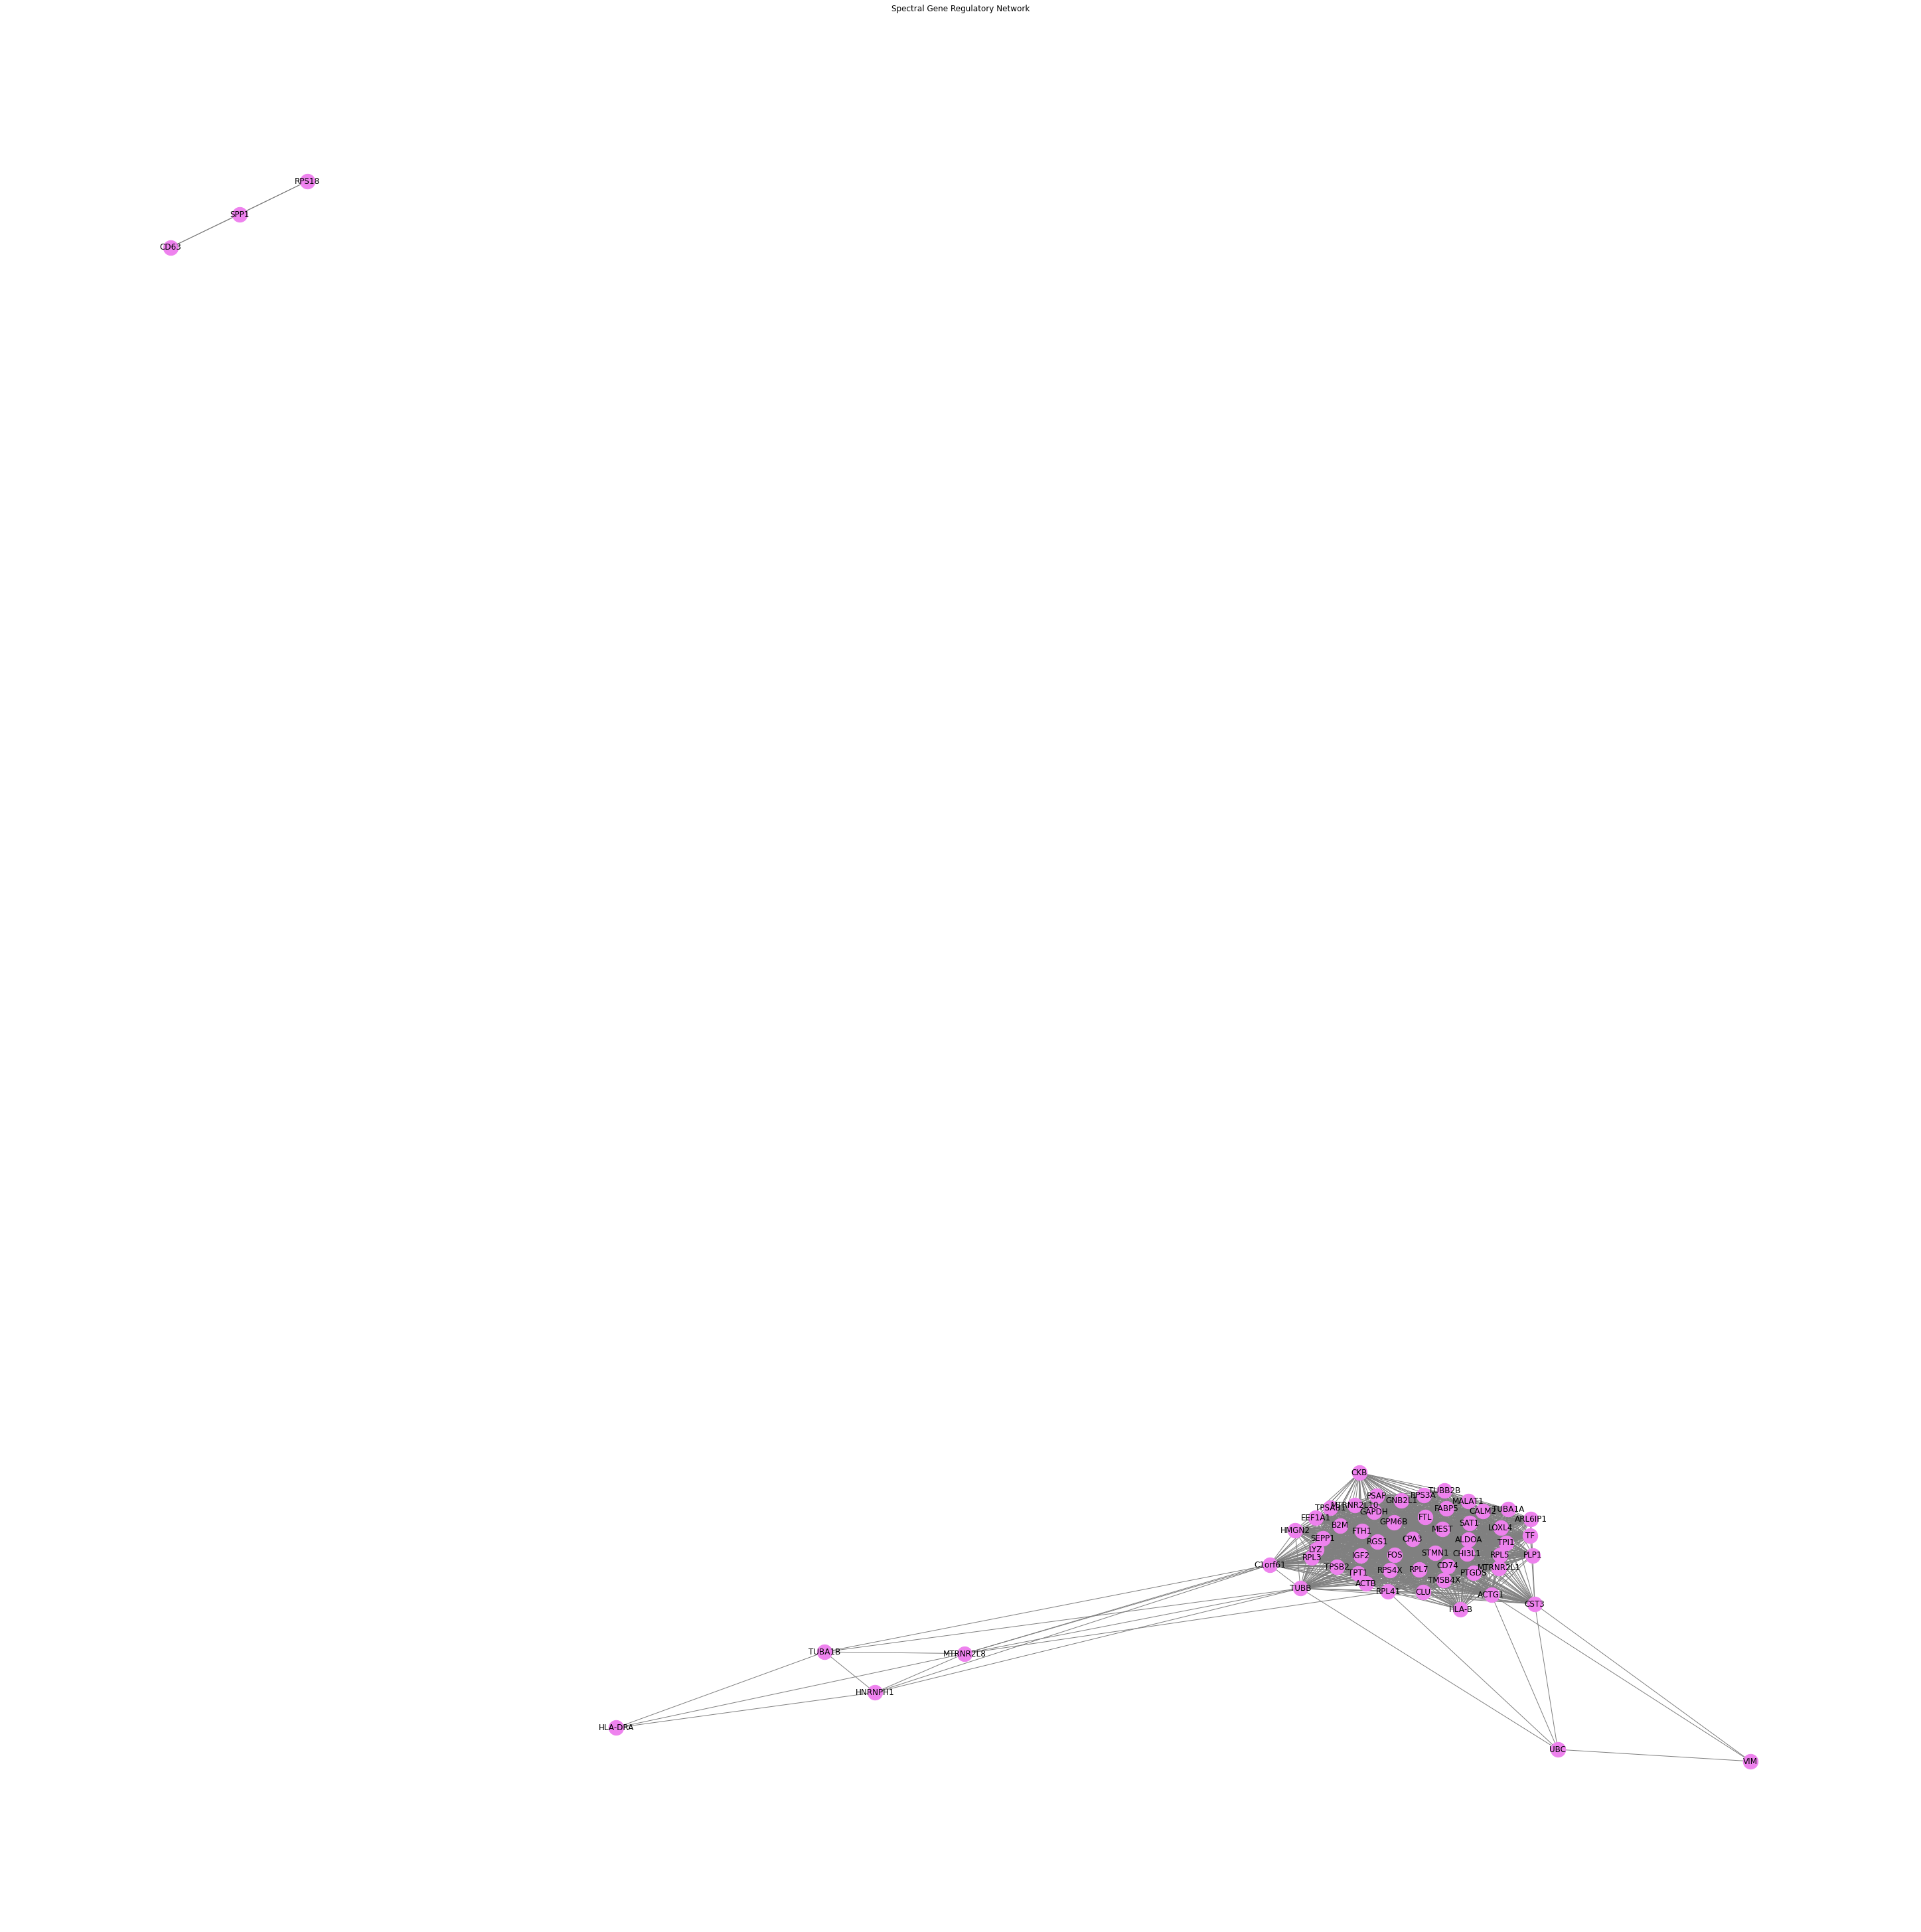

In [8]:
#Spectral Clustering GRN

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the Spectral Clustering genes
spectral_genes_df = pd.read_csv('Spectral_Louvain_Cluster_genes.csv')
spectral_genes = spectral_genes_df['Gene'].unique()

# Create a GRN using Spectral top genes
top_gene_data_spectral = expression_data[np.isin(genes, spectral_genes), :]
similarity_matrix_spectral = cosine_similarity(top_gene_data_spectral)
grn_graph_spectral = nx.Graph()

for i in range(similarity_matrix_spectral.shape[0]):
    for j in range(i + 1, similarity_matrix_spectral.shape[1]):
        if similarity_matrix_spectral[i, j] > 0.5:  # Set a threshold for similarity
            grn_graph_spectral.add_edge(spectral_genes[i], spectral_genes[j], weight=similarity_matrix_spectral[i, j])

# Compute centralities
centralities_spectral = {
    'betweenness': nx.betweenness_centrality(grn_graph_spectral),
    'degree': nx.degree_centrality(grn_graph_spectral),
    'eigenvector': nx.eigenvector_centrality(grn_graph_spectral),
    'closeness': nx.closeness_centrality(grn_graph_spectral)
}

# Save the centralities with gene names
centrality_spectral_df = pd.DataFrame(centralities_spectral).reset_index().rename(columns={'index': 'Gene'})
centrality_spectral_df.to_csv('Spectral_gene_centralities.csv', index=False)

# Plot the Spectral Clustering GRN
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(grn_graph_spectral)
nx.draw(grn_graph_spectral, pos, with_labels=True, node_size=500, node_color='violet', edge_color='gray')
plt.title('Spectral Gene Regulatory Network')
plt.savefig('Spectral_gene_regulatory_network.jpg', format='jpeg', dpi=300)
plt.show()


In [9]:
import pandas as pd
import numpy as np

# Load the log-normalized data
data_log_normalized = pd.read_csv('IDHWT_log_normalized.csv')
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Ensure expression_data is a 2D array
if expression_data.ndim == 1:
    expression_data = np.expand_dims(expression_data, axis=0)

# Load SVD and Spectral clustering gene lists
svd_genes_df = pd.read_csv('SVD_Louvain_Cluster_genes.csv')
spectral_genes_df = pd.read_csv('Spectral_Louvain_Cluster_genes.csv')

svd_genes = svd_genes_df['Gene'].unique()
spectral_genes = spectral_genes_df['Gene'].unique()

# Extract counts for SVD genes
svd_gene_indices = np.isin(genes, svd_genes)
svd_gene_data = expression_data[svd_gene_indices, :]

# Extract counts for Spectral genes
spectral_gene_indices = np.isin(genes, spectral_genes)
spectral_gene_data = expression_data[spectral_gene_indices, :]

# Ensure the extracted data is a 2D array
if svd_gene_data.ndim == 1:
    svd_gene_data = np.expand_dims(svd_gene_data, axis=0)
if spectral_gene_data.ndim == 1:
    spectral_gene_data = np.expand_dims(spectral_gene_data, axis=0)

# Binarize the data
svd_gene_data_binary = np.where(svd_gene_data > 0, 1, 0)
spectral_gene_data_binary = np.where(spectral_gene_data > 0, 1, 0)

# Optional: Print shapes for verification
print('SVD gene data shape:', svd_gene_data.shape)
print('Spectral gene data shape:', spectral_gene_data.shape)
print('SVD binary data shape:', svd_gene_data_binary.shape)
print('Spectral binary data shape:', spectral_gene_data_binary.shape)


SVD gene data shape: (651, 1943)
Spectral gene data shape: (64, 1943)
SVD binary data shape: (651, 1943)
Spectral binary data shape: (64, 1943)


SVD Gene Data BDM Changes (mean ± std): 223.44854070660523 ± 947.3197351114692
Spectral Gene Data BDM Changes (mean ± std): -961.9375 ± 1346.2849795246732


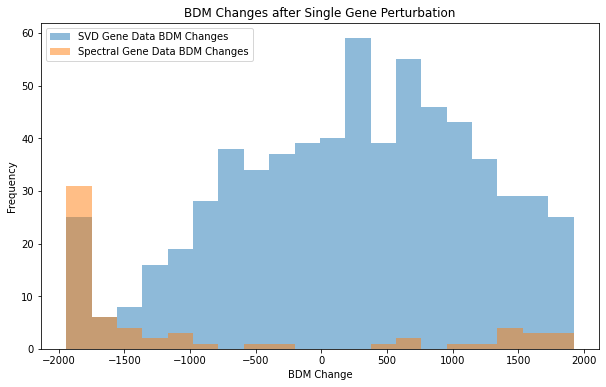

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simplified BDM computation function (actual implementation may vary)
def compute_bdm(matrix):
    # This function is a placeholder for the actual BDM computation.
    # Replace with the actual BDM calculation method or library.
    return np.sum(matrix)

# Function to perturb a single gene and return the perturbed matrix
def perturb_single_gene(matrix, gene_index):
    perturbed_matrix = matrix.copy()
    perturbed_matrix[gene_index, :] = 1 - perturbed_matrix[gene_index, :]  # Flip the entire row (gene)
    return perturbed_matrix

# Load the log-normalized data
data_log_normalized = pd.read_csv('IDHWT_log_normalized.csv')
data_log_normalized = data_log_normalized.drop_duplicates(subset=['Gene'])
genes = data_log_normalized['Gene'].values
expression_data = data_log_normalized.drop(columns=['Gene']).values

# Load SVD and Spectral clustering gene lists
svd_genes_df = pd.read_csv('SVD_Louvain_Cluster_genes.csv')
spectral_genes_df = pd.read_csv('Spectral_Louvain_Cluster_genes.csv')

svd_genes = svd_genes_df['Gene'].unique()
spectral_genes = spectral_genes_df['Gene'].unique()

# Extract counts for SVD genes
svd_gene_indices = np.isin(genes, svd_genes)
svd_gene_data = expression_data[svd_gene_indices, :]

# Extract counts for Spectral genes
spectral_gene_indices = np.isin(genes, spectral_genes)
spectral_gene_data = expression_data[spectral_gene_indices, :]

# Ensure the extracted data is a 2D array
if svd_gene_data.ndim == 1:
    svd_gene_data = np.expand_dims(svd_gene_data, axis=0)
if spectral_gene_data.ndim == 1:
    spectral_gene_data = np.expand_dims(spectral_gene_data, axis=0)

# Binarize the data
svd_gene_data_binary = np.where(svd_gene_data > 0, 1, 0)
spectral_gene_data_binary = np.where(spectral_gene_data > 0, 1, 0)

# Compute initial BDM for SVD and Spectral gene data
bdm_svd_initial = compute_bdm(svd_gene_data_binary)
bdm_spectral_initial = compute_bdm(spectral_gene_data_binary)

# Compute BDM changes for each gene perturbation
svd_bdm_changes = []
spectral_bdm_changes = []

# Calculate BDM changes for SVD genes
for i in range(svd_gene_data_binary.shape[0]):
    perturbed_svd = perturb_single_gene(svd_gene_data_binary, i)
    bdm_svd_perturbed = compute_bdm(perturbed_svd)
    svd_bdm_changes.append({
        'Gene': svd_genes[i],
        'BDM Change': bdm_svd_perturbed - bdm_svd_initial
    })

# Calculate BDM changes for Spectral genes
for i in range(spectral_gene_data_binary.shape[0]):
    perturbed_spectral = perturb_single_gene(spectral_gene_data_binary, i)
    bdm_spectral_perturbed = compute_bdm(perturbed_spectral)
    spectral_bdm_changes.append({
        'Gene': spectral_genes[i],
        'BDM Change': bdm_spectral_perturbed - bdm_spectral_initial
    })

# Save BDM changes to CSV files
svd_bdm_changes_df = pd.DataFrame(svd_bdm_changes)
spectral_bdm_changes_df = pd.DataFrame(spectral_bdm_changes)

svd_bdm_changes_df.to_csv('SVD_BDM_Changes_Single_Gene.csv', index=False)
spectral_bdm_changes_df.to_csv('Spectral_BDM_Changes_Single_Gene.csv', index=False)

# Summarize results
print("SVD Gene Data BDM Changes (mean ± std):", np.mean(svd_bdm_changes_df['BDM Change']), "±", np.std(svd_bdm_changes_df['BDM Change']))
print("Spectral Gene Data BDM Changes (mean ± std):", np.mean(spectral_bdm_changes_df['BDM Change']), "±", np.std(spectral_bdm_changes_df['BDM Change']))

# Plot BDM changes
plt.figure(figsize=(10, 6))
plt.hist(svd_bdm_changes_df['BDM Change'], bins=20, alpha=0.5, label='SVD Gene Data BDM Changes')
plt.hist(spectral_bdm_changes_df['BDM Change'], bins=20, alpha=0.5, label='Spectral Gene Data BDM Changes')
plt.title('BDM Changes after Single Gene Perturbation')
plt.xlabel('BDM Change')
plt.ylabel('Frequency')
plt.legend()
plt.show()
